<a href="https://colab.research.google.com/github/GuillermoPerez2905/Audio-Recognition-Program/blob/main/Entrenamiento_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#INSTALACIÓN DE PAQUETES EN LA MÁQUINA VIRTUAL

In [ ]:
!pip install python_speech_features
!pip install -U -q PyDrive

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas.util.testing as tm
import torch
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import GridSearchCV
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """


In [ ]:
#CARGAMOS LOS DATAFRAMES DEL GOOGLE DRIVE

In [ ]:
MFCC_mean_values = pd.read_csv('/content/drive/My Drive/Audios Ahumada/000_MFCC_mean_values.csv', index_col= 0)
MFCC_m_d_values = pd.read_csv('/content/drive/My Drive/Audios Ahumada/000_MFCC_m_d_values.csv', index_col= 0)
MFCC_m_s_values = pd.read_csv('/content/drive/My Drive/Audios Ahumada/000_MFCC_m_s_values.csv', index_col= 0)

In [ ]:
#GENERAMOS LA LISTA DE NOMBRES DE CADA AUDIO QUE LUEGO ASIGNAREMOS A LA VARIABLE y

In [ ]:
audio_names = []
for i in MFCC_mean_values.index:
  if 'm' in i.lower():
    audio_names.append(i.lower().split('m')[0])
  elif 't' in i.lower():
    audio_names.append(i.lower().split('t')[0])
for num in np.arange(0,len(audio_names)):
  if int(audio_names[num]) < 11:
    continue
  else:
    audio_names[num] = 'Mundo'

In [ ]:
#SEPARACIÓN DE VARIABLES EN ENTRENO Y TESTEO

In [ ]:
Xm_train, Xm_test, ym_train, ym_test = train_test_split(MFCC_mean_values,audio_names,
                                                    test_size=0.30, random_state=101)
Xmd_train, Xmd_test, ymd_train, ymd_test = train_test_split(MFCC_m_d_values,audio_names,
                                                    test_size=0.30, random_state=101)
Xms_train, Xms_test, yms_train, yms_test = train_test_split(MFCC_m_s_values,audio_names,
                                                    test_size=0.30, random_state=101)


In [ ]:
#OPTIMIZACIÓN DEL CLASFICADOR

In [ ]:
possibilities = {'C': [3,4,7,10,12], 'gamma': [0.1,0.01,0.001,0.0001,0.00001],
                 'kernel': ['rbf']}
model_m_GS= GridSearchCV(SVC(),possibilities,refit=True,verbose=3)
model_md_GS = GridSearchCV(SVC(),possibilities,refit=True,verbose=3)
model_ms_GS = GridSearchCV(SVC(),possibilities,refit=True,verbose=3)
model_m_GS.fit(Xm_train,ym_train)
model_md_GS.fit(Xmd_train, ymd_train)
model_ms_GS.fit(Xms_train,yms_train)
print(model_m_GS.best_params_)
print(model_md_GS.best_params_)
print(model_ms_GS.best_params_)

In [ ]:
#ESTABLECEMOS LAS VARIABLES ÓPTIMAS A CADA MODELO Y ENTRENAMOS EL MODELO CON
#MUESTRAS DE ENTRENAMIENTO

In [ ]:
model_m = SVC(C=4, gamma= 0.01)
model_m.fit(Xm_train, ym_train)
model_md = SVC(C=3, gamma = 0.01)
model_md.fit(Xmd_train, ymd_train)
model_ms = SVC(C= 3, gamma = 0.0001)
model_ms.fit(Xms_train, yms_train)

In [ ]:
#REALIZAMOS LA PREDICCIÓN DE LAS MUESTRAS DE TESTEO

In [ ]:
model_m_predictions = model_m.predict(Xm_test)
model_md_predictions = model_md.predict(Xmd_test)
model_ms_predictions = model_ms.predict(Xms_test)

In [ ]:
#CONTRUIMOS LA MATRIZ DE CONFUSIÓN PARA LOS 3 MODELOS

In [ ]:
Conf_m = pd.DataFrame(confusion_matrix(ym_test,model_m_predictions),
                       columns= ['1', '2', '3','4','5','6','7','8','9','10','Mundo'], 
                      index = ['1', '2', '3','4','5','6','7','8','9','10','Mundo'])

Conf_md = pd.DataFrame(confusion_matrix(ymd_test,model_md_predictions),
                       columns= ['1', '2', '3','4','5','6','7','8','9','10','Mundo'],
                       index= ['1', '2', '3','4','5','6','7','8','9','10','Mundo'])
Conf_ms = pd.DataFrame(confusion_matrix(yms_test,model_ms_predictions),
                       columns= ['1', '2', '3','4','5','6','7','8','9','10','Mundo'],
                       index= ['1', '2', '3','4','5','6','7','8','9','10','Mundo'])

In [ ]:
#CALCULAMOS EL MAPA DE CALOR DE CADA MATRIZ DE CONFUSIÓN

Text(0.5, 1.0, 'Mean Values')

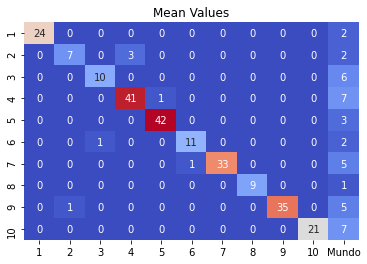

In [ ]:
mean = sns.heatmap(Conf_m.drop('Mundo', axis=0),cmap="coolwarm",annot= True,cbar=False)
mean.set_ylabel('')
mean.set_xlabel('')
mean.set_title('Mean Values')

Text(0.5, 1.0, 'Mean & Delta Values')

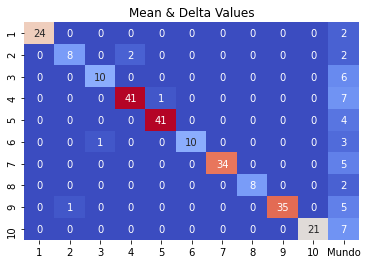

In [ ]:
mean_der = sns.heatmap(Conf_md.drop('Mundo', axis=0),cmap="coolwarm",annot= True,cbar=False)
mean_der.set_ylabel('')
mean_der.set_xlabel('')
mean_der.set_title('Mean & Delta Values')

Text(0.5, 1.0, 'Mean & Var Values')

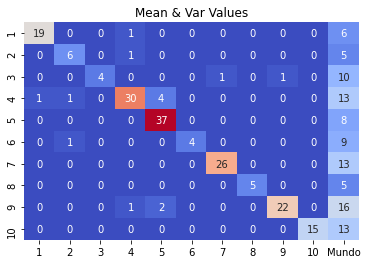

In [ ]:
mean_var = sns.heatmap(Conf_ms.drop('Mundo', axis=0),cmap="coolwarm",annot= True,cbar=False)
mean_var.set_ylabel('')
mean_var.set_xlabel('')
mean_var.set_title('Mean & Var Values')

In [ ]:
#OBTENEMOS LA INFORMACIÓN ESTADÍSTICA DE LA PREDICCIÓN DE CADA MODELO

In [ ]:
print(classification_report(ym_test,model_m_predictions))

              precision    recall  f1-score   support

         001       1.00      0.92      0.96        26
         002       0.88      0.58      0.70        12
         003       0.91      0.62      0.74        16
         004       0.93      0.84      0.88        49
         005       0.98      0.93      0.95        45
         006       0.92      0.79      0.85        14
         007       1.00      0.85      0.92        39
         008       1.00      0.90      0.95        10
         009       1.00      0.85      0.92        41
         010       1.00      0.75      0.86        28
       Mundo       0.91      1.00      0.95       417

    accuracy                           0.93       697
   macro avg       0.96      0.82      0.88       697
weighted avg       0.94      0.93      0.93       697



In [ ]:
print(classification_report(ymd_test,model_md_predictions))

              precision    recall  f1-score   support

         001       0.96      0.92      0.94        26
         002       0.89      0.67      0.76        12
         003       0.91      0.62      0.74        16
         004       0.95      0.84      0.89        49
         005       0.98      0.91      0.94        45
         006       1.00      0.71      0.83        14
         007       1.00      0.87      0.93        39
         008       1.00      0.80      0.89        10
         009       1.00      0.85      0.92        41
         010       1.00      0.75      0.86        28
       Mundo       0.91      1.00      0.95       417

    accuracy                           0.93       697
   macro avg       0.96      0.81      0.88       697
weighted avg       0.93      0.93      0.93       697



In [ ]:
print(classification_report(yms_test,model_ms_predictions))

              precision    recall  f1-score   support

         001       0.86      0.73      0.79        26
         002       0.75      0.50      0.60        12
         003       0.57      0.25      0.35        16
         004       0.81      0.61      0.70        49
         005       0.82      0.82      0.82        45
         006       1.00      0.29      0.44        14
         007       0.93      0.67      0.78        39
         008       0.71      0.50      0.59        10
         009       0.79      0.54      0.64        41
         010       1.00      0.54      0.70        28
       Mundo       0.80      0.95      0.87       417

    accuracy                           0.81       697
   macro avg       0.82      0.58      0.66       697
weighted avg       0.82      0.81      0.80       697



In [ ]:
path_m = F"/content/drive/My Drive/Audios Ahumada/{'model_media.pt'}" 
torch.save(model_m, path_m)
path_md = F"/content/drive/My Drive/Audios Ahumada/{'model_med_der.pt'}" 
torch.save(model_md, path_md)
path_ms = F"/content/drive/My Drive/Audios Ahumada/{'model_med_var.pt'}" 
torch.save(model_ms, path_ms)